In [1]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

In [2]:
path = '../data/judicial_review_of_congress_database_1789-2018.xlsx'
df = pd.read_excel(path)
df.columns = df.columns.str.lower().str.replace(r'[ -]', '_')
print(df.shape)
df.head()

(1308, 25)


,case,citation,date,year,decade,decision,decision2,effect,stat_name,stat_cite,...,area2,lndmrk,lnddtl,att_gen,cert,reversd,crs,gvt_prty,dissent,h_ct
0,United States v. Yale Todd,"*54 U.S. 40, 52",2/17/1794,1794,1790,2,1,struck down on face,Invalid Pensions Act,1 Stat. 243,...,NaN,0.0,0.0,1,0,0.0,0.0,1,0,0
1,Penhallow v. Doane's Adm'rs,003 U.S. 054,2/24/1795,1795,1790,0,0,upheld,Court of Appeals Resolution,17 JCC 459,...,NaN,0.0,0.0,1,0,1.0,0.0,0,0,1
2,Hylton v. United States,003 U.S. 171,3/8/1796,1796,1790,0,0,upheld,Carriage Tax Act,1 Stat. 373,...,NaN,0.0,0.0,1,0,0.0,0.0,1,0,1
3,United States v. La Vengeance,003 U.S. 297,8/11/1796,1796,1790,0,0,upheld,Arms Exportation Act,1 Stat. 369,...,1.0,0.0,0.0,1,0,0.0,0.0,1,0,1
4,Mossman v. Higginson,004 U.S. 12,8/11/1800,1800,1800,1,1,struck down as applied,Judiciary Act of 1789,1 Stat. 73,...,6.0,1.0,0.0,0,0,0.0,0.0,0,0,0


In [3]:
def wrangle(X):
    X = X.copy()
    
    # 'decision', 'decision2', and 'effect' contain target information
    # 'citation', 'date', 'year', 'decade', and 'dissent' are not known until after a decision
    # 'pl_#' congress info is duplicated in 'congress' and the other info is random
    # 's_date' is dropped in favor of the slightly coarser 'congress' feature
    # 'lndmark', 'lnddtl', and 'crs' are not relevant
    
    columns_to_drop = ['decision', 'decision2', 'effect', 'citation', 'date', 'year', 'decade',
                       'dissent', 'pl_#', 's_date', 'lndmrk', 'lnddtl', 'crs']
    
    # Create features for cases in which the United States is the first or last party
    X['us_first_party'] = X['case'].str.startswith('United States v', na=False).astype(int)
    X['us_last_party'] = X['case'].str.endswith('v. United States', na=False).astype(int)
    columns_to_drop.append('case')
    
    # 'reversd' is not known before a decision, but we can engineer a feature describing the lower court's decision
    swap = X['reversd'] == 1
    decision = X['decision2'] == 1
    lower_court_decision = [not dec if swap else dec for dec, swap in zip(decision, swap)]
    X['lower_court_decision'] = np.array(lower_court_decision).astype(int)
    columns_to_drop.append('reversd')
    
    # For 'area2' values: keep 1 though 6, and add 7 in place of nulls
    X['area2'] = X['area2'].fillna(value=7).astype(int)
    
    # Drop unnecessary or unknowable features
    X = X.drop(columns=columns_to_drop)
    
    # return the wrangled dataframe
    return X

In [4]:
# Leave 1,000 observations for cross-validation
train, test = train_test_split(df, test_size=308, stratify=df['decision'], random_state=42)
train.shape, test.shape

((1000, 25), (308, 25))

In [5]:
# Create targets and wrangle dataframe. Note that the target is not dropped before
# wrangling so that it can be used to create 'lower_court_decision' feature
y_train = train['decision2']
y_test = test['decision2']

X_train = wrangle(train)
X_test = wrangle(test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1000, 13), (308, 13), (1000,), (308,))

In [6]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=60, oob_score=True, random_state=42, max_depth=10, max_features=5)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['stat_name', 'stat_cite'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'stat_name',
                                          'data_type': dtype('O'),
                                          'mapping': Revenue Act of 1925                                                                        1
Hepburn Act (Interstate Commerce)                                                          2
National Highway System Designation Act of 1995                                            3
National Labor Relations Act                                                               4
80 Stat. 378                                                                               5
Pos...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstr

In [7]:
from joblib import dump
dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

In [8]:
# simple one feature model for testing
df_1 = X_train['area1']

In [9]:
df_1.head()

500     4
326     4
1239    5
630     6
922     2
Name: area1, dtype: int64

In [10]:
pipeline_1 = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=60, random_state=42)
)

pipeline_1.fit(df_1, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=None,
                                        oob_score=False, ran

In [11]:
from joblib import dump
dump(pipeline_1, 'pipeline_1.joblib')

['pipeline_1.joblib']

In [12]:
# simple two feature model for testing
df_2 = X_train[['area1', 'lower_court_decision']]

In [13]:
df_2.head()

,area1,lower_court_decision
500,4,1
326,4,1
1239,5,1
630,6,0
922,2,1


In [14]:
pipeline_2 = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=60, random_state=42)
)

pipeline_2.fit(df_2, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=60, n_jobs=None,
                                        oob_score=False, ran

In [15]:
from joblib import dump
dump(pipeline_2, 'pipeline_2.joblib')

['pipeline_2.joblib']

In [16]:
#make charts
ax = train['year'].plot.hist(bins=22, title='Federal Cases Decided by the Supreme Court')
ax.set_xlabel("Year");
fig = ax.get_figure()
fig.savefig('./cases_per_year.jpg')

In [17]:
areas = train[['area1', 'decision2']].copy()
areas['constitutional'] = areas['decision2'] == 0
areas['unconstitional'] = areas['decision2']
areas.drop(columns='decision2', inplace=True)
areas['constitutional'] = areas['constitutional'].astype('int')
names = {1: 'Due Process', 2: 'Substantive Rights', 3: 'Equality', 4: 'Economic', 5: 'Federalism', 6: 'Separation of Powers'}
areas['area1'] = areas['area1'].replace(names)
areas.head()

,area1,constitutional,unconstitional
500,Economic,0,1
326,Economic,1,0
1239,Federalism,1,0
630,Separation of Powers,1,0
922,Substantive Rights,1,0


In [18]:
pt = pd.pivot_table(areas, values=['constitutional', 'unconstitional'], index='area1', aggfunc=np.sum)
pt

,constitutional,unconstitional
area1,,
Due Process,174,72
Economic,182,45
Equality,23,13
Federalism,186,48
Separation of Powers,97,34
Substantive Rights,74,52


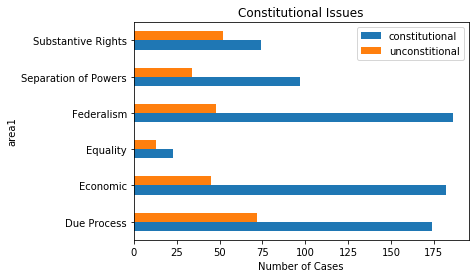

In [19]:
ax = pt.plot.barh(title='Constitutional Issues');
ax.set_xlabel("Number of Cases");
fig = ax.get_figure()
fig.savefig('./cases_per_issue.jpg')

In [20]:
# simple three feature model for testing
df_3 = X_train[['area1', 'lower_court_decision', 'congress']]
df_3.head()

,area1,lower_court_decision,congress
500,4,1,69
326,4,1,59
1239,5,1,104
630,6,0,74
922,2,1,89


In [21]:
pipeline_3 = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=60, random_state=42)
)

pipeline_3.fit(df_3, y_train)

dump(pipeline_3, 'pipeline_3.joblib')

['pipeline_3.joblib']